In [1]:
from __future__ import print_function

#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import seaborn as sns

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

def plot_seq_scores(importance_scores, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :

    importance_scores = importance_scores.T

    fig = plt.figure(figsize=figsize)
    
    ref_seq = ""
    for j in range(importance_scores.shape[1]) :
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))
        
        if argmax_nt == 0 :
            ref_seq += "A"
        elif argmax_nt == 1 :
            ref_seq += "C"
        elif argmax_nt == 2 :
            ref_seq += "G"
        elif argmax_nt == 3 :
            ref_seq += "T"

    ax = plt.gca()
    
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, len(ref_seq)))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()

def plot_pwm_2(pwm, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :
    
    fig = plt.figure(figsize=figsize)

    ax = plt.gca()
    
    height_base = 0.
    logo_height = 1.0
    
    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i]# * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if ii == 0 :
                dna_letter_at(nt, j + 0.5, height_base, nt_prob * logo_height, ax, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]]) * logo_height # * conservation[j]
                dna_letter_at(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, pwm.shape[0]))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            min(0., np.min(np.sum(pwm, axis=-1))) - 0.01 * np.max(np.abs(np.sum(pwm, axis=-1))),
            max(0., np.max(np.sum(pwm, axis=-1))) + 0.01 * np.max(np.abs(np.sum(pwm, axis=-1)))
        )
    
    print(np.min(np.sum(pwm, axis=-1)) - 0.1 * np.max(np.abs(np.sum(pwm, axis=-1))))
    print(np.max(np.sum(pwm, axis=-1)) + 0.1 * np.max(np.abs(np.sum(pwm, axis=-1))))
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()

#One-hot-encoder
class SequenceEncoder :
    
    def __init__(self, encoder_type_id, encode_dims) :
        self.encoder_type_id = encoder_type_id
        self.encode_dims = encode_dims
    
    def encode(self, seq) :
        raise NotImplementedError()
    
    def encode_inplace(self, seq, encoding) :
        raise NotImplementedError()
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def decode(self, encoding) :
        raise NotImplementedError()
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def __call__(self, seq) :
        return self.encode(seq)
    
class OneHotEncoder(SequenceEncoder) :
    
    def __init__(self, seq_length, channel_map) :
        super(OneHotEncoder, self).__init__('onehot', (seq_length, len(channel_map)))
        
        self.seq_len = seq_length
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += self.decode_map[self.n_channels - 1]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)


Using TensorFlow backend.
2023-04-26 22:20:30.224508: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


2023-04-26 22:20:31.766289: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2023-04-26 22:20:31.768326: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bf88f47d80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-26 22:20:31.768357: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-04-26 22:20:31.771186: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-04-26 22:20:32.491342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-26 22:20:32.491921: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bf88f3f6f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-2

In [2]:

df = pd.read_csv('polyadb_features_pas_3_utr3_perturb.csv', sep='\t')

save_dict = np.load("polyadb_features_pas_3_utr3_perturb.npz")
x, m, l, c, y = save_dict['x'], save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y']

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))


x.shape = (5267, 10, 205, 4)
m.shape = (5267, 10)
l.shape = (5267, 10)
c.shape = (5267, 10, 28)
y.shape = (5267, 10, 28)


In [3]:
#Load APARENT Resnet

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5'

save_dir = os.path.join(os.getcwd(), '')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent = load_model(model_path)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/opt/conda/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
#Score all sequences with APARENT (use sum of cuts to capture OR-like logic)

isoform_start = 77
isoform_end = 127

s = np.zeros((x.shape[0], x.shape[1]))
for k in range(x.shape[1]) :
    
    print("Predicting for PAS #" + str(k) + "...")
    
    onehots = x[:, k:k+1, ...]
    
    fake_lib = np.zeros((onehots.shape[0], 13))
    fake_lib[:, 11] = 1.
    
    #Pad
    n_pad = 32 - onehots.shape[0] % 32 if onehots.shape[0] % 32 != 0 else 0

    fake_lib = np.concatenate([fake_lib, np.zeros((n_pad, 13))], axis=0)
    onehots = np.concatenate([onehots, np.zeros((n_pad, 1, 205, 4))], axis=0)
    
    _, pred_cuts = aparent.predict(x=[onehots, fake_lib], batch_size=32, verbose=1)
    
    if n_pad > 0 :
        pred_cuts = pred_cuts[:-n_pad, :]
    
    pred_iso = np.sum(pred_cuts[:, isoform_start:isoform_end], axis=1)
    pred_logit = np.log(pred_iso / (1. - pred_iso))
    
    s[:, k] = pred_logit[:]

s = s * m
s = np.clip(s, -10., 10.)


In [3]:
#Cache/Load APARENT2 baseline score

#np.save("polyadb_features_pas_3_utr3_perturb_aparent2_all_scores", s)
s = np.load("polyadb_features_pas_3_utr3_perturb_aparent2_all_scores.npy")

print(s.shape)


(5267, 10)


In [4]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i:i+1, dist_index[i], :])

y_dist = np.concatenate(y_dist, axis=0)

print(y_dist.shape)


(5267, 28)


In [5]:
#Load tissue-specific PAS model and generate scores for select tissue types

subset_cell_types = np.array([
    'NT',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'FIP1L1',
    'NUDT21',
    'RBBP6',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

subset_cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(subset_cell_types)
}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [6]:
#Define tissue-/cell- types

cell_types = np.array([
    'rpm',
    'NT',
    'CDC73',
    'CPSF1',
    'CPSF2',
    'CPSF3',
    'CPSF3L',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'CTR9',
    'FIP1L1',
    'LEO1',
    'NUDT21',
    'PABPC1',
    'PABPN1',
    'PAF1',
    'PAPOLA',
    'PCF11',
    'RBBP6',
    'RPRD1A',
    'RPRD1B',
    'SCAF8',
    'SF3A1',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [7]:
#PAS network definition

import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, LocallyConnected2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Conv1D, LocallyConnected1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

def load_pas_network(n_cell_types=1, n_dil=6, n_channels=32, filter_size=3, filter_size_0=5, nonneg_up_to=0) :
    
    conv_0 = Conv2D(n_channels, kernel_size=(1, filter_size_0), kernel_constraint=keras.constraints.NonNeg() if nonneg_up_to > 0 else None, padding='same', activation='relu', name='pasnet_conv2d_0')
    
    drop_0 = Dropout(0.5, name='pasnet_drop_0')
    
    convs = [
        Conv2D(n_channels, kernel_size=(1, filter_size), kernel_constraint=keras.constraints.NonNeg() if i < nonneg_up_to else None, padding='same', activation='relu', dilation_rate=2**i, name='pasnet_conv2d_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    drops = [
        Dropout(0.5, name='pasnet_drop_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    adds = [
        Lambda(lambda x: x[0] + x[1], name='pasnet_add_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    pool = Lambda(lambda x: K.mean(x, axis=(1, 2)))

    final_dense = Dense(n_cell_types*3, activation='linear', kernel_initializer='zeros', bias_initializer='zeros', name='pasnet_dense_2')
    final_reshape = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], n_cell_types, 3)))
    
    def _net_func(sequence_input) :
        
        x = drop_0(conv_0(sequence_input))

        for i in range(1, n_dil+1):
            x = adds[i-1]([drops[i-1](convs[i-1](x)), x])

        pool_out = pool(x)

        final_dense_out = final_dense(pool_out)
        
        return final_reshape(final_dense_out)

    return _net_func

def _load_pas_model(model_name, n_cell_types=1) :
    
    seq_input = Input(shape=(1, 205, 4), name='seq_input')
    
    pas_net = load_pas_network(n_cell_types=n_cell_types)
    
    pred_output = pas_net(seq_input)
    
    pas_model = Model(seq_input, pred_output)
    pas_model.load_weights(model_name, by_name=True)
    pas_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(0.1))
    
    return pas_model

def _predict_multi_pas(pas_model, x, batch_size=32) :
    
    y_preds = []
    for k in range(x.shape[1]) :
        y_preds.append(pas_model.predict(x=[x[:, k:k+1, ...]], batch_size=32)[:, None, ...])
    
    return np.concatenate(y_preds, axis=1)


In [8]:
#Model parameters

n_bootstraps = 5
n_cell_types = subset_cell_types.shape[0]


In [9]:
#Predict tissue model scores

tissue_models = [
    _load_pas_model("saved_models/perturb_resnet_utr3_covar_drop_ensemble_" + str(bootstrap_ix) + "_pas_model.h5", n_cell_types=n_cell_types) for bootstrap_ix in range(n_bootstraps)
]
'''
ts_ensemble = np.concatenate([_predict_multi_pas(tissue_models[bootstrap_ix], x, batch_size=32)[..., None] for bootstrap_ix in range(n_bootstraps)], axis=-1)

ts = np.mean(ts_ensemble, axis=-1)

print("ts.shape = " + str(ts.shape))
'''

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


'\nts_ensemble = np.concatenate([_predict_multi_pas(tissue_models[bootstrap_ix], x, batch_size=32)[..., None] for bootstrap_ix in range(n_bootstraps)], axis=-1)\n\nts = np.mean(ts_ensemble, axis=-1)\n\nprint("ts.shape = " + str(ts.shape))\n'

In [10]:
#Cache/Load tissue scores
'''
np.save("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts_ensemble", ts_ensemble)
np.save("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts", ts)
'''
ts_ensemble = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts_ensemble.npy")
ts = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts.npy")

print(ts_ensemble.shape)
print(ts.shape)


(5267, 10, 11, 3, 5)
(5267, 10, 11, 3)


In [11]:
#Compute normalization statistics

cell_type_ixs = [cell_type_dict[ct] for ct in subset_cell_types.tolist()]

flat_x = np.reshape(x, (x.shape[0] * x.shape[1], 1, 205, 4))
flat_ts_ensemble = np.reshape(ts_ensemble, (x.shape[0] * x.shape[1], n_cell_types, n_bootstraps, 3))
flat_ts = np.reshape(ts, (x.shape[0] * x.shape[1], n_cell_types, 3))
flat_y = np.reshape(y[:, :, cell_type_ixs], (x.shape[0] * x.shape[1], n_cell_types))
flat_gene_ind = np.reshape(np.tile(np.arange(x.shape[0])[:, None], (1, x.shape[1])), (x.shape[0] * x.shape[1],))
flat_pas_ind = np.reshape(np.tile(np.arange(x.shape[1])[None, :], (x.shape[0], 1)), (x.shape[0] * x.shape[1],))

flat_m = np.reshape(m, (x.shape[0] * x.shape[1],))
flat_dist_mask = np.reshape(dist_mask, (x.shape[0] * x.shape[1],))

flat_keep_index = np.nonzero(flat_m >= 1)[0]

flat_x = flat_x[flat_keep_index, ...]
flat_ts_ensemble = flat_ts_ensemble[flat_keep_index, ...]
flat_ts = flat_ts[flat_keep_index, ...]
flat_y = flat_y[flat_keep_index, ...]
flat_gene_ind = flat_gene_ind[flat_keep_index, ...]
flat_pas_ind = flat_pas_ind[flat_keep_index, ...]

flat_m = flat_m[flat_keep_index, ...]
flat_dist_mask = flat_dist_mask[flat_keep_index, ...]


In [12]:
#Construct masks for proximal/middle/distal sites

flat_prox_mask = np.array((flat_pas_ind == 0), dtype=np.float32)
flat_middle_mask = 1. - flat_dist_mask - flat_prox_mask

flat_masks = [
    flat_prox_mask,
    flat_middle_mask,
    flat_dist_mask
]


In [13]:
#Load processed (flattened) PAS IDs from original dataframe

flat_ids = np.load("polyadb_features_pas_3_utr3_perturb_flat_ids.npy", allow_pickle=True)

#Compile and flatten gene names
flat_gene_names = []
for _, row in df.iterrows() :
    flat_gene_names.extend([row['gene'] for k in range(m.shape[1]) if row['pas_exists_' + str(k)] == 1])

flat_gene_names = np.array(flat_gene_names, dtype=object)


In [14]:
#Re-load gated importance scores

flat_scores = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_flat_g_scores.npy")
flat_scores = np.tile(flat_scores, (1, 1, 1, 1, 1, 4)) * flat_x[None, None, ...]

print("flat_scores.shape = " + str(flat_scores.shape))

#Re-load gated importance scores (bootstrap replicates)

n_bootstraps = 3

flat_scores_ensemble = []

for bootstrap_ix in range(n_bootstraps) :
    flat_scores_curr = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_flat_g_scores_bootstrap_" + str(bootstrap_ix) + ".npy")
    flat_scores_curr = np.tile(flat_scores_curr, (1, 1, 1, 1, 1, 4)) * flat_x[None, None, ...]
    
    flat_scores_ensemble.append(flat_scores_curr)
    
    print("(bootstrap_ix = " + str(bootstrap_ix) + ") flat_scores.shape = " + str(flat_scores_curr.shape))


flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 0) flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 1) flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 2) flat_scores.shape = (11, 3, 14764, 1, 205, 4)


In [15]:
#Get flat representation of sequences as dataframe

seqs = flat_x[:, 0, ...]

seqs_str = []
for i in range(seqs.shape[0]) :
    seq = ""
    for j in range(seqs.shape[1]) :
        if seqs[i, j, 0] == 1. :
            seq += "A"
        elif seqs[i, j, 1] == 1. :
            seq += "C"
        elif seqs[i, j, 2] == 1. :
            seq += "G"
        elif seqs[i, j, 3] == 1. :
            seq += "T"
    
    seqs_str.append(seq)

seqs_str = np.array(seqs_str, dtype=np.object)

df = pd.DataFrame({
    "gene" : flat_gene_names.tolist(),
    "pas_id" : flat_ids.tolist(),
    "seq" : seqs_str.tolist(),
})

print("len(df) = " + str(len(df)))


len(df) = 14764


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [93]:
#Define global list of restricted substrings not allowed to be created by the shuffling operation

shuffle_filter = [
    'TGTA',
    'TGTG',
    'GTGT',
    'TGTC',
    'GTCT',
    'TCTG',
    'CTGT',
    'TCTC',
    'CTCT',
    'TTTT',
    'GTTT',
    'TTTG',
    'CTTT',
    'TTTC',
    'ATTT',
    'TTTA'
]

#Code for combinatorially shuffling sequence motifs and storing these sequence mutants

def _scramble_sequences(save_prefix, df, cell_type_1_ix=0, cell_type_2_ix=1, pred_cell_type_2_ixs=None, score_ix=0, seq_start=0, seq_end=205, bg_mode='unif', shuffle_region='up', n_shuffles=5, shuffle_window_size=6) :
    
    if pred_cell_type_2_ixs is None :
        pred_cell_type_2_ixs = [cell_type_2_ix]
    
    save_name = "epistasis_ablate_" + save_prefix + "/cell_type_1_ix_" + str(cell_type_1_ix) + "_cell_type_2_ix_" + str(cell_type_2_ix) + "_score_ix_" + str(score_ix) + "_n_sequences_" + str(len(df)) + "_window_size_" + str(window_size)
    
    if not os.path.exists("./samples/" + save_name.split("/")[0]) :
        os.makedirs("./samples/" + save_name.split("/")[0])
    
    #Get sequence encoder
    acgt_encoder = OneHotEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})
    
    #Construct backgrounds
    
    #Native mononucleotide background frequencies
    mononuc_dicts_native = [
        {
            'up' : np.zeros(4, dtype='float32'),
            'dn' : np.zeros(4, dtype='float32'),
        } for score_ixx in range(len(flat_masks))
    ]

    for i in range(flat_x.shape[0]) :
        for score_ixx in range(len(flat_masks)) :
            if flat_masks[score_ixx][i] == 1 :
                mononuc_dicts_native[score_ixx]['up'] += np.sum(flat_x[i, 0, 0:70, :], axis=0)
                mononuc_dicts_native[score_ixx]['dn'] += np.sum(flat_x[i, 0, 76:146, :], axis=0)

    for score_ixx in range(len(flat_masks)) :
        mononuc_dicts_native[score_ixx]['up'] /= np.sum(mononuc_dicts_native[score_ixx]['up'])
        mononuc_dicts_native[score_ixx]['dn'] /= np.sum(mononuc_dicts_native[score_ixx]['dn'])
    
    #Uniform frequencies
    mononuc_dicts_unif = [
        {
            'up' : 0.25 * np.ones(4, dtype='float32'),
            'dn' : 0.25 * np.ones(4, dtype='float32'),
        } for score_ixx in range(len(flat_masks))
    ]
    
    #GT-depleted frequencies
    mononuc_dicts_less_gt = [
        {
            'up' : np.array([0.30, 0.30, 0.25, 0.15], dtype='float32'),
            'dn' : np.array([0.30, 0.30, 0.25, 0.15], dtype='float32'),
        } for score_ixx in range(len(flat_masks))
    ]
    
    #GT-enriched frequencies
    mononuc_dicts_more_gt = [
        {
            'up' : np.array([0.20, 0.15, 0.25, 0.40], dtype='float32'),
            'dn' : np.array([0.20, 0.15, 0.25, 0.40], dtype='float32'),
        } for score_ixx in range(len(flat_masks))
    ]

    #Pos frequencies
    bg_dict = None
    if bg_mode == 'native' :
        bg_dict = mononuc_dicts_native[score_ix]
    elif bg_mode == 'unif' :
        bg_dict = mononuc_dicts_unif[score_ix]
    elif bg_mode == 'less_gt' :
        bg_dict = mononuc_dicts_less_gt[score_ix]
    elif bg_mode == 'more_gt' :
        bg_dict = mononuc_dicts_more_gt[score_ix]
    
    #Save sequences to file
    with open("./samples/" + save_name + ".txt", "w") as f :
        
        diff_score_col_str = ""
        for pred_cell_type_2_ix in pred_cell_type_2_ixs :
            for sc_ix in range(3) :
                diff_score_col_str += "\tdiff_ct_" + str(pred_cell_type_2_ix) + "_score_" + str(sc_ix)
        
        f.write("gene_id\tpas_id\texperiment\tseq" + diff_score_col_str + "\n")
        
        for i, [_, row] in enumerate(df.iterrows()) :
            gene_id = row['gene']
            pas_id = row['pas_id']
            experiment = 'wt'
            wt_seq = row['seq'][seq_start:seq_end]
            
            wt_x = acgt_encoder.encode(wt_seq)[None, None, ...]
            
            pred_curr = []
            for bootstrap_ix in range(n_bootstraps) :
                pred_curr.append(tissue_models[bootstrap_ix].predict(x=[
                    wt_x
                ], batch_size=1, verbose=False))
            
            pred_curr = np.mean(np.concatenate(pred_curr, axis=0), axis=0)
            
            diff_score_str = ""
            for pred_cell_type_2_ix in pred_cell_type_2_ixs :
                for sc_ix in range(3) :
                    diff_score_str += "\t" + str(round(pred_curr[cell_type_1_ix, sc_ix] - pred_curr[pred_cell_type_2_ix, sc_ix], 4))
            
            #Store wildtype sequence
            f.write(gene_id + "\t" + pas_id + "\t" + experiment + "\t" + wt_seq + diff_score_str + "\n")
            
            #Get motif position 1
            argmax_pos_1 = row['pos_1']
            
            #Get motif position 2
            argmax_pos_2 = row['pos_2']
            
            #Get motif position null
            argmax_pos_null = row['pos_null']
            
            bg_nuc = bg_dict[shuffle_region] if shuffle_region in ['up', 'dn'] else None
            
            even_odd = shuffle_window_size % 2
            
            shuffled_seqs_1, shuffled_seqs_2, shuffled_seqs_null = None, None, None
            if shuffle_region in ['up', 'dn'] :
                shuffled_seqs_1 = _shuffle_seq(wt_seq, [[argmax_pos_1, argmax_pos_1 + shuffle_window_size]], bg_nuc, n_samples=n_shuffles, window_size=shuffle_window_size)
                shuffled_seqs_2 = _shuffle_seq(wt_seq, [[argmax_pos_2, argmax_pos_2 + shuffle_window_size]], bg_nuc, n_samples=n_shuffles, window_size=shuffle_window_size)
                shuffled_seqs_null = _shuffle_seq(wt_seq, [[argmax_pos_null, argmax_pos_null + shuffle_window_size]], bg_nuc, n_samples=n_shuffles, window_size=shuffle_window_size)
            else :
                flank_len = ((shuffle_window_size + even_odd) - 6) // 2
                
                shuffled_seqs_1 = _shuffle_cse(wt_seq, [[70-flank_len, 76+flank_len]], n_samples=n_shuffles)
                
                if argmax_pos_1 <= 76+flank_len-1 :
                    argmax_pos_1 += (76+flank_len) - argmax_pos_1
                    
                if argmax_pos_null <= 76+flank_len-1 :
                    argmax_pos_null += (76+flank_len) - argmax_pos_null
                
                shuffled_seqs_2 = _shuffle_seq(wt_seq, [[argmax_pos_1, argmax_pos_1 + shuffle_window_size]], bg_nuc, n_samples=n_shuffles, window_size=shuffle_window_size)
                shuffled_seqs_null = _shuffle_seq(wt_seq, [[argmax_pos_null, argmax_pos_null + shuffle_window_size]], bg_nuc, n_samples=n_shuffles, window_size=shuffle_window_size)
            
            #Construct sequences where both regions are shuffled simultaneously
            shuffled_seqs_1_and_2 = []
            shuffled_seqs_1_and_null = []
            for shuffled_seq_1, shuffled_seq_2, shuffled_seq_null in zip(shuffled_seqs_1, shuffled_seqs_2, shuffled_seqs_null) :
                if shuffle_region in ['up', 'dn'] :
                    if argmax_pos_1 < argmax_pos_2 :
                        shuffled_seq_1_and_2 = wt_seq[:argmax_pos_1] + shuffled_seq_1[argmax_pos_1:argmax_pos_1 + shuffle_window_size] + wt_seq[argmax_pos_1 + shuffle_window_size:argmax_pos_2] + shuffled_seq_2[argmax_pos_2:argmax_pos_2 + shuffle_window_size] + wt_seq[argmax_pos_2 + shuffle_window_size:]
                    else :
                        shuffled_seq_1_and_2 = wt_seq[:argmax_pos_2] + shuffled_seq_2[argmax_pos_2:argmax_pos_2 + shuffle_window_size] + wt_seq[argmax_pos_2 + shuffle_window_size:argmax_pos_1] + shuffled_seq_1[argmax_pos_1:argmax_pos_1 + shuffle_window_size] + wt_seq[argmax_pos_1 + shuffle_window_size:]
                    
                    if argmax_pos_1 < argmax_pos_null :
                        shuffled_seq_1_and_null = wt_seq[:argmax_pos_1] + shuffled_seq_1[argmax_pos_1:argmax_pos_1 + shuffle_window_size] + wt_seq[argmax_pos_1 + shuffle_window_size:argmax_pos_null] + shuffled_seq_null[argmax_pos_null:argmax_pos_null + shuffle_window_size] + wt_seq[argmax_pos_null + shuffle_window_size:]
                    else :
                        shuffled_seq_1_and_null = wt_seq[:argmax_pos_null] + shuffled_seq_null[argmax_pos_null:argmax_pos_null + shuffle_window_size] + wt_seq[argmax_pos_null + shuffle_window_size:argmax_pos_1] + shuffled_seq_1[argmax_pos_1:argmax_pos_1 + shuffle_window_size] + wt_seq[argmax_pos_1 + shuffle_window_size:]
                else : #CSE
                    shuffled_seq_1_and_2 = wt_seq[:70] + shuffled_seq_1[70:76] + wt_seq[76:argmax_pos_1] + shuffled_seq_2[argmax_pos_1:argmax_pos_1 + shuffle_window_size] + wt_seq[argmax_pos_1:]
                    shuffled_seq_1_and_null = wt_seq[:70] + shuffled_seq_null[70:76] + wt_seq[76:argmax_pos_null] + shuffled_seq_null[argmax_pos_null:argmax_pos_null + shuffle_window_size] + wt_seq[argmax_pos_null:]
                
                if len(wt_seq) != 205 or len(shuffled_seq_1) != 205 or len(shuffled_seq_2) != 205 or len(shuffled_seq_1_and_2) != 205 or len(shuffled_seq_1_and_null) != 205 :
                    print("Err, length.")
                    
                    print(argmax_pos_1)
                    print(argmax_pos_2)
                    print(argmax_pos_null)
                    
                    print(wt_seq)
                    print(shuffled_seq_1)
                    print(shuffled_seq_2)
                    print(shuffled_seq_null)
                    print(shuffled_seq_1_and_2)
                    print(shuffled_seq_1_and_null)
                    
                    print("" + 1)
                
                shuffled_seqs_1_and_2.append(shuffled_seq_1_and_2)
                shuffled_seqs_1_and_null.append(shuffled_seq_1_and_null)
            
            for shuffle_i in range(len(shuffled_seqs_1)) :
                
                shuffled_seq = shuffled_seqs_1[shuffle_i]
                
                flat_x_shuffled = acgt_encoder.encode(shuffled_seq)[None, None, ...]
                
                pred_curr = []
                for bootstrap_ix in range(n_bootstraps) :
                    pred_curr.append(tissue_models[bootstrap_ix].predict(x=[
                        flat_x_shuffled
                    ], batch_size=1, verbose=False))

                pred_curr = np.mean(np.concatenate(pred_curr, axis=0), axis=0)

                diff_score_str = ""
                for pred_cell_type_2_ix in pred_cell_type_2_ixs :
                    for sc_ix in range(3) :
                        diff_score_str += "\t" + str(round(pred_curr[cell_type_1_ix, sc_ix] - pred_curr[pred_cell_type_2_ix, sc_ix], 4))

                #Store shuffled sequence
                f.write(gene_id + "\t" + pas_id + "\t" + "shuffle_1_pos_" + str(argmax_pos_1) + "_repeat" + str(shuffle_i) + "\t" + shuffled_seq + diff_score_str + "\n")
            
            for shuffle_i in range(len(shuffled_seqs_2)) :
                
                shuffled_seq = shuffled_seqs_2[shuffle_i]
                
                flat_x_shuffled = acgt_encoder.encode(shuffled_seq)[None, None, ...]
                
                pred_curr = []
                for bootstrap_ix in range(n_bootstraps) :
                    pred_curr.append(tissue_models[bootstrap_ix].predict(x=[
                        flat_x_shuffled
                    ], batch_size=1, verbose=False))

                pred_curr = np.mean(np.concatenate(pred_curr, axis=0), axis=0)

                diff_score_str = ""
                for pred_cell_type_2_ix in pred_cell_type_2_ixs :
                    for sc_ix in range(3) :
                        diff_score_str += "\t" + str(round(pred_curr[cell_type_1_ix, sc_ix] - pred_curr[pred_cell_type_2_ix, sc_ix], 4))

                #Store shuffled sequence
                f.write(gene_id + "\t" + pas_id + "\t" + "shuffle_2_pos_" + str(argmax_pos_2) + "_repeat" + str(shuffle_i) + "\t" + shuffled_seq + diff_score_str + "\n")
            
            for shuffle_i in range(len(shuffled_seqs_null)) :
                
                shuffled_seq = shuffled_seqs_null[shuffle_i]
                
                flat_x_shuffled = acgt_encoder.encode(shuffled_seq)[None, None, ...]
                
                pred_curr = []
                for bootstrap_ix in range(n_bootstraps) :
                    pred_curr.append(tissue_models[bootstrap_ix].predict(x=[
                        flat_x_shuffled
                    ], batch_size=1, verbose=False))

                pred_curr = np.mean(np.concatenate(pred_curr, axis=0), axis=0)

                diff_score_str = ""
                for pred_cell_type_2_ix in pred_cell_type_2_ixs :
                    for sc_ix in range(3) :
                        diff_score_str += "\t" + str(round(pred_curr[cell_type_1_ix, sc_ix] - pred_curr[pred_cell_type_2_ix, sc_ix], 4))

                #Store shuffled sequence
                f.write(gene_id + "\t" + pas_id + "\t" + "shuffle_null_pos_" + str(argmax_pos_null) + "_repeat" + str(shuffle_i) + "\t" + shuffled_seq + diff_score_str + "\n")
            
            for shuffle_i in range(len(shuffled_seqs_1_and_2)) :
                
                shuffled_seq = shuffled_seqs_1_and_2[shuffle_i]
                
                flat_x_shuffled = acgt_encoder.encode(shuffled_seq)[None, None, ...]
                
                pred_curr = []
                for bootstrap_ix in range(n_bootstraps) :
                    pred_curr.append(tissue_models[bootstrap_ix].predict(x=[
                        flat_x_shuffled
                    ], batch_size=1, verbose=False))

                pred_curr = np.mean(np.concatenate(pred_curr, axis=0), axis=0)

                diff_score_str = ""
                for pred_cell_type_2_ix in pred_cell_type_2_ixs :
                    for sc_ix in range(3) :
                        diff_score_str += "\t" + str(round(pred_curr[cell_type_1_ix, sc_ix] - pred_curr[pred_cell_type_2_ix, sc_ix], 4))

                #Store shuffled sequence
                f.write(gene_id + "\t" + pas_id + "\t" + "shuffle_1_and_2_pos_" + str(argmax_pos_1) + "_and_" + str(argmax_pos_2) + "_repeat" + str(shuffle_i) + "\t" + shuffled_seq + diff_score_str + "\n")
            
            for shuffle_i in range(len(shuffled_seqs_1_and_null)) :
                
                shuffled_seq = shuffled_seqs_1_and_null[shuffle_i]
                
                flat_x_shuffled = acgt_encoder.encode(shuffled_seq)[None, None, ...]
                
                pred_curr = []
                for bootstrap_ix in range(n_bootstraps) :
                    pred_curr.append(tissue_models[bootstrap_ix].predict(x=[
                        flat_x_shuffled
                    ], batch_size=1, verbose=False))

                pred_curr = np.mean(np.concatenate(pred_curr, axis=0), axis=0)

                diff_score_str = ""
                for pred_cell_type_2_ix in pred_cell_type_2_ixs :
                    for sc_ix in range(3) :
                        diff_score_str += "\t" + str(round(pred_curr[cell_type_1_ix, sc_ix] - pred_curr[pred_cell_type_2_ix, sc_ix], 4))

                #Store shuffled sequence
                f.write(gene_id + "\t" + pas_id + "\t" + "shuffle_1_and_null_pos_" + str(argmax_pos_1) + "_and_" + str(argmax_pos_2) + "_repeat" + str(shuffle_i) + "\t" + shuffled_seq + diff_score_str + "\n")

def _shuffle_seq(seq, ablate_regions, bg, n_samples=5, window_size=9) :
    
    nts = ['A', 'C', 'G', 'T']
    
    seqs_shuffled = []
    
    for [ablate_start, ablate_end] in ablate_regions :
        
        for sample_ix in range(n_samples) :
            
            rand_seq = None
            passes_filter = False
            
            while not passes_filter :
                rand_seq = "".join(np.random.choice(nts, size=(window_size,), p=bg, replace=True).tolist())
                
                passes_filter = True
                for filter_substr in shuffle_filter :
                    if filter_substr in rand_seq :
                        passes_filter = False
                        break
            
            ablated_seq = seq[:ablate_start] + rand_seq + seq[ablate_end:]

            seqs_shuffled.append(ablated_seq)

    return seqs_shuffled

def _shuffle_cse(seq, ablate_regions, n_samples=5) :
    
    nts = ['A', 'C', 'G', 'T']
    
    cses = [
        'TATAAA',
        'GATAAA',
        'CATAAA',
        'AGTAAA',
        'ACTAAA',
        'AATATA',
        'AATACA',
        'AATAGA',
        'AATAAT',
        'AATAAC',
    ]
    
    seqs_shuffled = []
    
    for [ablate_start, ablate_end] in ablate_regions :
        
        flank_len = ((ablate_end - ablate_start) - 6) // 2
        
        for sample_ix in range(n_samples) :
            
            rand_f1 = "".join(np.random.choice(nts, size=(flank_len,), p=[0.1, 0.35, 0.35, 0.2], replace=True).tolist())
            rand_f2 = "".join(np.random.choice(nts, size=(flank_len,), p=[0.1, 0.35, 0.35, 0.2], replace=True).tolist())
            
            rand_seq = rand_f1 + np.random.choice(cses) + rand_f2
            ablated_seq = seq[:ablate_start] + rand_seq + seq[ablate_end:]

            seqs_shuffled.append(ablated_seq)

    return seqs_shuffled

def _inspect_epistatis_ablation(experiment_prefix, n_sequences=25, window_size=6, cell_type_1_ix=0, cell_type_2_ix=6, score_ix=2, pred_cell_type_2_ix=6, bg_mode='unif', epi_sign=-1.) :

    df_abl = pd.read_csv("samples/epistasis_ablate_" + experiment_prefix + "/cell_type_1_ix_0_cell_type_2_ix_" + str(cell_type_2_ix) + "_score_ix_" + str(score_ix) + "_n_sequences_" + str(n_sequences) + "_window_size_" + str(window_size) + ".txt", sep='\t')

    #Specify cell type index to use for predictions
    df_abl['diff_score_0'] = df_abl['diff_ct_' + str(pred_cell_type_2_ix) + '_score_0']
    df_abl['diff_score_1'] = df_abl['diff_ct_' + str(pred_cell_type_2_ix) + '_score_1']
    df_abl['diff_score_2'] = df_abl['diff_ct_' + str(pred_cell_type_2_ix) + '_score_2']

    #Get wt dataframe
    df_abl_wt = df_abl.query("experiment == 'wt'").copy().reset_index(drop=True)

    #Get non-wt dataframes
    df_abl = df_abl.query("experiment != 'wt'").copy().reset_index(drop=True)

    #Augment with wt predictions
    df_abl = df_abl.join(df_abl_wt[['pas_id', 'seq', 'diff_score_0', 'diff_score_1', 'diff_score_2']].set_index("pas_id"), on='pas_id', how='inner', rsuffix='_wt').copy().reset_index(drop=True)

    #Aggregate over replicates

    df_abl['superexperiment'] = df_abl['experiment'].apply(lambda x: x.split("_repeat")[0])
    df_abl = df_abl.groupby(['pas_id', 'superexperiment']).agg({
        'gene_id' : 'first',
        'experiment' : 'first',
        'seq_wt' : 'first',
        'diff_score_0' : 'mean',
        'diff_score_1' : 'mean',
        'diff_score_2' : 'mean',
        'diff_score_0_wt' : 'first',
        'diff_score_1_wt' : 'first',
        'diff_score_2_wt' : 'first'
    }).copy().reset_index().reset_index(drop=True)

    #Get shuffle_1 dataframe
    df_abl_1 = df_abl.loc[df_abl['experiment'].str.contains("shuffle_1_p")].copy().reset_index(drop=True)

    #Get shuffle_2 dataframe
    df_abl_2 = df_abl.loc[df_abl['experiment'].str.contains("shuffle_2_p")].copy().reset_index(drop=True)

    #Get shuffle_null dataframe
    df_abl_2_null = df_abl.loc[df_abl['experiment'].str.contains("shuffle_null_p")].copy().reset_index(drop=True)

    #Get shuffle_1_and_2 dataframe
    df_abl_1_and_2 = df_abl.loc[df_abl['experiment'].str.contains("shuffle_1_and_2_p")].copy().reset_index(drop=True)

    #Get shuffle_1_and_null dataframe
    df_abl_1_and_null = df_abl.loc[df_abl['experiment'].str.contains("shuffle_1_and_null_p")].copy().reset_index(drop=True)

    #Calculate final epistasis scores
    df_abl = df_abl_1_and_2.join(df_abl_1[['pas_id', 'diff_score_0', 'diff_score_1', 'diff_score_2']].set_index('pas_id'), on='pas_id', rsuffix='_abl_1').copy().reset_index(drop=True)
    df_abl = df_abl.join(df_abl_2[['pas_id', 'diff_score_0', 'diff_score_1', 'diff_score_2']].set_index('pas_id'), on='pas_id', rsuffix='_abl_2').copy().reset_index(drop=True)

    df_abl = df_abl.rename(columns={
        'diff_score_0' : 'diff_score_0_abl_1_and_2',
        'diff_score_1' : 'diff_score_1_abl_1_and_2',
        'diff_score_2' : 'diff_score_2_abl_1_and_2',
    })

    #Calculate final epistasis scores (null)
    df_abl_null = df_abl_1_and_null.join(df_abl_1[['pas_id', 'diff_score_0', 'diff_score_1', 'diff_score_2']].set_index('pas_id'), on='pas_id', rsuffix='_abl_1').copy().reset_index(drop=True)
    df_abl_null = df_abl_null.join(df_abl_2_null[['pas_id', 'diff_score_0', 'diff_score_1', 'diff_score_2']].set_index('pas_id'), on='pas_id', rsuffix='_abl_null').copy().reset_index(drop=True)

    df_abl_null = df_abl_null.rename(columns={
        'diff_score_0' : 'diff_score_0_abl_1_and_null',
        'diff_score_1' : 'diff_score_1_abl_1_and_null',
        'diff_score_2' : 'diff_score_2_abl_1_and_null',
    })

    for sc_ix in range(3) :
        df_abl['epi_score_' + str(sc_ix)] = (df_abl['diff_score_' + str(sc_ix) + '_abl_1_and_2'] - df_abl['diff_score_' + str(sc_ix) + '_wt']) - ((df_abl['diff_score_' + str(sc_ix) + '_abl_1'] - df_abl['diff_score_' + str(sc_ix) + '_wt']) + (df_abl['diff_score_' + str(sc_ix) + '_abl_2'] - df_abl['diff_score_' + str(sc_ix) + '_wt']))

    for sc_ix in range(3) :
        df_abl_null['epi_score_' + str(sc_ix)] = (df_abl_null['diff_score_' + str(sc_ix) + '_abl_1_and_null'] - df_abl_null['diff_score_' + str(sc_ix) + '_wt']) - ((df_abl_null['diff_score_' + str(sc_ix) + '_abl_1'] - df_abl_null['diff_score_' + str(sc_ix) + '_wt']) + (df_abl_null['diff_score_' + str(sc_ix) + '_abl_null'] - df_abl_null['diff_score_' + str(sc_ix) + '_wt']))

    #Get motif scramble positions
    df_abl_1_and_2['pos_1'] = df_abl_1_and_2['superexperiment'].apply(lambda x: int(x.split("_pos_")[1].split("_and_")[0]))
    df_abl_1_and_2['pos_2'] = df_abl_1_and_2['superexperiment'].apply(lambda x: int(x.split("_pos_")[1].split("_and_")[1]))

    print("len(df_abl_wt) = " + str(len(df_abl_wt)))
    print("len(df_abl_1) = " + str(len(df_abl_1)))
    print("len(df_abl_2) = " + str(len(df_abl_2)))
    print("len(df_abl_2_null) = " + str(len(df_abl_2_null)))
    print("len(df_abl_1_and_2) = " + str(len(df_abl_1_and_2)))
    print("len(df_abl_1_and_null) = " + str(len(df_abl_1_and_null)))
    print("len(df_abl) = " + str(len(df_abl)))
    print("len(df_abl_null) = " + str(len(df_abl_null)))

    #Visualize perturbation scores (vs null controls)
    import seaborn as sns
    from scipy.stats import ranksums

    pred_score_ixs = [2, 0]

    for pred_score_ix in pred_score_ixs :

        var_scores_1 = np.array((df_abl_1['diff_score_' + str(pred_score_ix)] - df_abl_1['diff_score_' + str(pred_score_ix) + '_wt']).values)
        var_scores_2 = np.array((df_abl_2['diff_score_' + str(pred_score_ix)] - df_abl_2['diff_score_' + str(pred_score_ix) + '_wt']).values)

        var_scores = (var_scores_1 + var_scores_2) / 2.

        var_scores_null = np.array((df_abl_2_null['diff_score_' + str(pred_score_ix)] - df_abl_2_null['diff_score_' + str(pred_score_ix) + '_wt']).values)

        s_val, p_val = ranksums(var_scores, var_scores_null, alternative='two-sided')

        print("wilcoxon p = " + str(p_val))

        f = plt.figure(figsize=(6, 4))

        sns.stripplot(data=[np.exp(var_scores), np.exp(var_scores_null)], alpha=0.9, jitter=0.25, palette=['red', 'green'])
        sns.boxplot(data=[np.exp(var_scores), np.exp(var_scores_null)], linewidth=2, fliersize=0., palette=['lightcoral', 'lightgreen'])

        plt.xticks([0, 1], ["Motif", "Matched Control"], fontsize=12)
        plt.yticks(fontsize=12)

        plt.ylabel("Perturbation (odds ratio); " + ("(Prox)" if pred_score_ix == 0 else "(Dist)"), fontsize=12)

        plt.tight_layout()

        plt.show()

    #Visualize epistatis scores (vs null controls)

    pred_score_ixs = [2, 0]

    for pred_score_ix in pred_score_ixs :

        epi_scores = np.array(df_abl['epi_score_' + str(pred_score_ix)].values)
        epi_scores_null = np.array(df_abl_null['epi_score_' + str(pred_score_ix)].values)

        s_val, p_val = ranksums(epi_sign * epi_scores, epi_sign*epi_scores_null, alternative='two-sided')

        print("wilcoxon p = " + str(p_val))

        f = plt.figure(figsize=(6, 4))

        sns.stripplot(data=[np.exp(epi_sign * -epi_scores), np.exp(epi_sign * -epi_scores_null)], alpha=0.9, jitter=0.25, palette=['red', 'green'])
        sns.boxplot(data=[np.exp(epi_sign * -epi_scores), np.exp(epi_sign * -epi_scores_null)], linewidth=2, fliersize=0., palette=['lightcoral', 'lightgreen'])

        plt.xticks([0, 1], ["Motif Pair", "Matched Controls"], fontsize=12)
        plt.yticks(fontsize=12)

        plt.ylabel("Epistasis (odds ratio); " + ("(Prox)" if pred_score_ix == 0 else "(Dist)"), fontsize=12)

        plt.tight_layout()

        plt.show()

    #Plot histogram of motif shuffle positions and distances
    shuffle_poses = []
    motif_distances = []
    for _, row in df_abl_1_and_2.iterrows() :
        for j in range(row['pos_1'], row['pos_1']+window_size) :
            shuffle_poses.append(j)
        for j in range(row['pos_2'], row['pos_2']+window_size) :
            shuffle_poses.append(j)

        motif_distances.append(np.abs(row['pos_2'] - row['pos_1']) - window_size)

    shuffle_poses = np.array(shuffle_poses, dtype='float32')
    motif_distances = np.array(motif_distances, dtype='float32')

    #Positions
    f = plt.figure(figsize=(6, 4))

    plt.hist(shuffle_poses, bins=146 // 2, range=(0, 146), color='red')

    plt.axvline(x=70, linewidth=2, linestyle='--', color='black')
    plt.axvline(x=76, linewidth=2, linestyle='--', color='black')

    plt.xticks([0, 70, 76, 145], [0, 70, 76, 145], rotation=60, fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Position", fontsize=12)
    plt.ylabel("# Times Position Shuffled", fontsize=12)

    plt.xlim(0, 145)

    plt.tight_layout()

    plt.show()

    #Pairwise distances
    f = plt.figure(figsize=(6, 4))

    plt.hist(motif_distances, bins=20, range=(0, 40), color='red')

    plt.xticks([0, 5, 10, 20, 40], [0, 5, 10, 20, 40], rotation=60, fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Motif Distance (bp)", fontsize=12)
    plt.ylabel("# Occurrences", fontsize=12)

    plt.xlim(0, 40)

    plt.tight_layout()

    plt.show()
    
    #Visualize motif distances vs epistastic score
    from scipy.stats import spearmanr

    for pred_score_ix in pred_score_ixs :

        df_abl['pos_1'] = df_abl['superexperiment'].apply(lambda x: int(x.split("_pos_")[1].split("_and_")[0]))
        df_abl['pos_2'] = df_abl['superexperiment'].apply(lambda x: int(x.split("_pos_")[1].split("_and_")[1]))

        df_abl['distance'] = np.abs(df_abl['pos_1'] - df_abl['pos_2']) - window_size

        r_val = spearmanr(df_abl['distance'].values, df_abl['epi_score_2'].values)[0]

        f = plt.figure(figsize=(3, 3))

        plt.scatter(df_abl['distance'].values, df_abl['epi_score_' + str(pred_score_ix)].values, s=8, alpha=0.9, color='black')

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.xlabel("Motif Distance", fontsize=12)
        plt.ylabel("Epistasis (log); " + ("(Prox)" if pred_score_ix == 0 else "(Dist)"), fontsize=12)

        plt.title("r = " + str(round(r_val, 2)), fontsize=12)

        plt.tight_layout()

        plt.show()
    
    return df_abl, df_abl_null


In [45]:
#Find sequences with two wildtype TGTA motifs (in multiple compositions)

df['n_tgta'] = df['seq'].str.slice(0, 70).str.count("TGTA")
df['cano_cse'] = df['seq'].str.slice(70, 76).str.contains("AATAAA|ATTAAA|AGTAAA|TATAAA|GATAAA|CATAAA")
df['use_cse'] = df['seq'].str.slice(0, 70).str.contains("AATAAA|ATTAAA")

df['A'] = df['seq'].str.slice(0, 70).str.count("A") / 70.
df['C'] = df['seq'].str.slice(0, 70).str.count("C") / 70.
df['G'] = df['seq'].str.slice(0, 70).str.count("G") / 70.
df['T'] = df['seq'].str.slice(0, 70).str.count("T") / 70.

df['gc_composition'] = (df['G'] + df['C'] >= 0.40)
df['at_composition'] = (df['A'] + df['T'] >= 0.70)

gc_wt_index = np.nonzero((((df['n_tgta'] == 2) & (df['cano_cse'] == 1)) & ((df['gc_composition'] == True) & (df['use_cse'] == 0))).values)[0]
at_wt_index = np.nonzero((((df['n_tgta'] == 2) & (df['cano_cse'] == 1)) & ((df['at_composition'] == True) & (df['use_cse'] == 0))).values)[0]

df_wt_gc = df.iloc[gc_wt_index].copy().reset_index(drop=True)
df_wt_at = df.iloc[at_wt_index].copy().reset_index(drop=True)

print("len(df_wt_gc) = " + str(len(df_wt_gc)))
print("len(df_wt_at) = " + str(len(df_wt_at)))


len(df_wt_gc) = 206
len(df_wt_at) = 650


In [48]:

pd.options.display.max_colwidth = 100

df_wt_gc['seq'].str.slice(0, 70)


0      TGTAATGTACAGTTCCTTCTGAAGCAAGCAACATCAGCAGCAGCAGCAGCAGCAGCACAATTCTGTGTTT
1      TCCAGAGAGTTCAAGGGATTGGGGAAAGAGAGGCGTCAAGTCATTTGCACTTTGTACCTGTAAGTTAGGT
2      GGCGGATGGTGGCTATGGCAAGAAAACTTGATGTGTATGGTAAGTGTAAATGAAGGTCTATCACAAATGC
3      TGTACATATTTTGCAGTGTTTCACAGGAGAAAGTGGCCTTAACTGCCCCTTATTCTCTCTCCACGTTGTA
4      ACGCTGTCGCCGCGCGGTTTCCCTTCGCAGATGTGTATACTCATGATAGGTCAGAAAGTGTATCCGCTAC
                                        ...                                  
201    CAGCCGCCCACCAAGGATGTCATCTGTAGAATGGGTGGAGGGCAGGGGTTTATTTGGTGTATATTTTTAC
202    CTCAACCCTCCCTTTGTAGTGTGAAAGCAGCTGTAGACAGTAAGTAAACAAATGGGTGTGGCTGTGTTCT
203    ATGTGTGTAGATTTCATGCTCGACACTTACCACTCACCTATCAACAGATCATCCTGCTTGACTGTAACAA
204    CTCTTAGCAAAGGTGAATGCCAGATGTAAATGGCGCCTCTGGGCAAAGGAGGCTTGTATTTTGCACATTT
205    GCATAACTTGGGATCCCGGGCTGTAACTTGCTCTTTTGTTTCCCACCCCCCTGACATGTATGTGTGCTTT
Name: seq, Length: 206, dtype: object

In [17]:
#Find sequences with two wildtype TGTA motifs (AT-rich flank composition)

n_wt = 100

window_size = 6

df['n_tgta'] = df['seq'].str.slice(0, 70).str.count("TGTA")
df['n_tgta_at'] = df['seq'].str.slice(0, 70).str.count("TTGTAA|TTGTAT|ATGTAA|ATGTAT")
df['cano_cse'] = df['seq'].str.slice(70, 76).str.contains("AATAAA|ATTAAA|AGTAAA|TATAAA|GATAAA|CATAAA")
df['use_cse'] = df['seq'].str.slice(0, 70).str.contains("AATAAA|ATTAAA")

wt_index = np.nonzero(((((df['n_tgta_at'] == 2) & (df['n_tgta'] == 2)) & (df['cano_cse'] == 1)) & (df['use_cse'] == 0)).values)[0]

#Shuffle index positions
np.random.shuffle(wt_index)

df_tgta_at = df.iloc[wt_index].copy().reset_index(drop=True)

#Find motif positions
df_tgta_at['pos_1'] = df_tgta_at['seq'].apply(lambda x: x[:70].find("TGTA") - 1)
df_tgta_at['pos_2'] = df_tgta_at['seq'].apply(lambda x: 70 - x[:70][::-1].find("ATGT") - 4 - 1)

#Sample null positions (controls)
def _find_null_pos(row) :
    pos_1 = row['pos_1']
    pos_2 = row['pos_2']
    
    poses_null = []
    pos_null = 0
    while pos_null < 70 - window_size :
        if not (pos_null + window_size - 1 >= pos_1 and pos_null < pos_1 + window_size) and not (pos_null + window_size - 1 >= pos_2 and pos_null < pos_2 + window_size) :
            poses_null.append(pos_null) 
    
        pos_null += 1
    
    pos_null = np.random.choice(poses_null)
    
    return pos_null

df_tgta_at['pos_null'] = df_tgta_at.apply(_find_null_pos, axis=1)

#Filter on minimum spacing to avoid flank overlap
df_tgta_at['motif_distance'] = np.abs(df_tgta_at['pos_2'] - df_tgta_at['pos_1']) - window_size

df_tgta_at = df_tgta_at.query("motif_distance >= 0 and pos_1 >= 0 and pos_2 >= 0").iloc[-n_wt:].copy().reset_index(drop=True)

print("len(df_tgta_at) = " + str(len(df_tgta_at)))


len(df_tgta_at) = 100


In [18]:
#Store ablated wt sequences and their scrambled mutants

#Parameter configuration
experiment_prefix = 'TGTA_flank_AT'

df_exp = df_tgta_at

window_size = 6

cell_type_1_ix = 0
cell_type_2_ix = 6

score_ix = 2

pred_cell_type_2_ixs = [6]

shuffle_region = 'up'

bg_mode = 'unif'

_scramble_sequences(
    experiment_prefix,
    df_exp,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    pred_cell_type_2_ixs=pred_cell_type_2_ixs,
    score_ix=score_ix,
    shuffle_region=shuffle_region,
    bg_mode=bg_mode,
    n_shuffles=5,
    shuffle_window_size=window_size,
)


2023-04-26 22:21:00.445337: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2023-04-26 22:21:00.686131: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8


len(df_abl_wt) = 100
len(df_abl_1) = 100
len(df_abl_2) = 100
len(df_abl_2_null) = 100
len(df_abl_1_and_2) = 100
len(df_abl_1_and_null) = 100
len(df_abl) = 100
len(df_abl_null) = 100
wilcoxon p = 4.268090020998585e-27


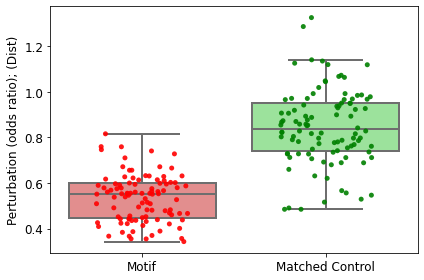

wilcoxon p = 4.2621690697826355e-24


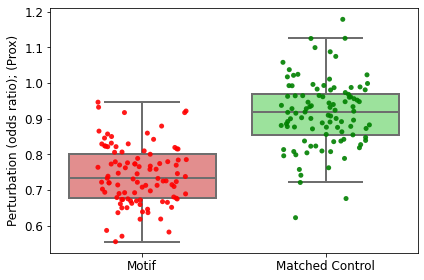

wilcoxon p = 1.173476528974495e-20


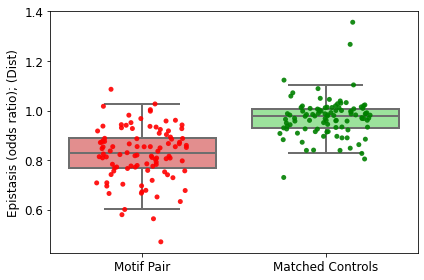

wilcoxon p = 4.125160824477042e-08


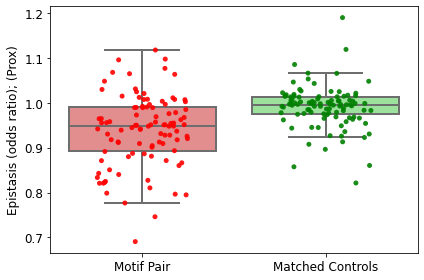

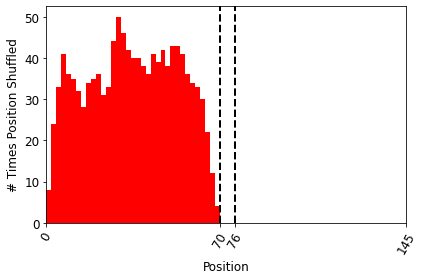

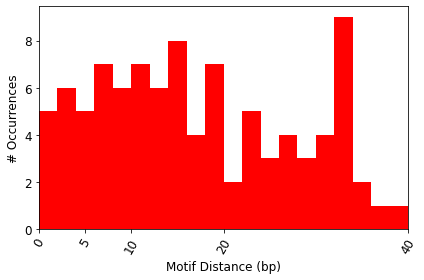

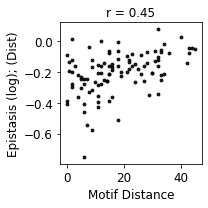

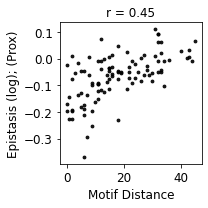

In [30]:
#Inspect epistasis ablation designs

experiment_prefix = 'TGTA_flank_AT'

n_sequences = 100

window_size = 6

cell_type_1_ix = 0
cell_type_2_ix = 6

score_ix = 2

pred_cell_type_2_ix = 6

bg_mode = 'unif'

_, _ = _inspect_epistatis_ablation(
    experiment_prefix,
    n_sequences=n_sequences,
    window_size=window_size,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    score_ix=score_ix,
    pred_cell_type_2_ix=pred_cell_type_2_ix,
    bg_mode=bg_mode
)


In [75]:
#Find sequences with two wildtype TGTA motifs (GC-rich flank composition)

n_wt = 20

window_size = 6

df['n_tgta'] = df['seq'].str.slice(0, 70).str.count("TGTA")
df['n_tgta_gc'] = df['seq'].str.slice(0, 70).str.count("TGTAGG")
df['cano_cse'] = df['seq'].str.slice(70, 76).str.contains("AATAAA|ATTAAA|AGTAAA|TATAAA|GATAAA|CATAAA")
df['use_cse'] = df['seq'].str.slice(0, 70).str.contains("AATAAA|ATTAAA")

wt_index = np.nonzero(((((df['n_tgta_gc'] == 1) & (df['n_tgta'] == 2)) & (df['cano_cse'] == 1)) & (df['use_cse'] == 0)).values)[0]

#Shuffle index positions
np.random.shuffle(wt_index)

df_tgta_gc = df.iloc[wt_index].copy().reset_index(drop=True)

#Find motif positions
df_tgta_gc['pos_1'] = df_tgta_gc['seq'].apply(lambda x: x[:70].find("TGTA") - 1)
df_tgta_gc['pos_2'] = df_tgta_gc['seq'].apply(lambda x: 70 - x[:70][::-1].find("ATGT") - 4 - 1)

#Sample null positions (controls)
def _find_null_pos(row) :
    pos_1 = row['pos_1']
    pos_2 = row['pos_2']
    
    poses_null = []
    pos_null = 0
    while pos_null < 70 - window_size :
        if not (pos_null + window_size - 1 >= pos_1 and pos_null < pos_1 + window_size) and not (pos_null + window_size - 1 >= pos_2 and pos_null < pos_2 + window_size) :
            poses_null.append(pos_null) 
    
        pos_null += 1
    
    pos_null = np.random.choice(poses_null)
    
    return pos_null

df_tgta_gc['pos_null'] = df_tgta_gc.apply(_find_null_pos, axis=1)

#Filter on minimum spacing to avoid flank overlap
df_tgta_gc['motif_distance'] = np.abs(df_tgta_gc['pos_2'] - df_tgta_gc['pos_1']) - window_size

df_tgta_gc = df_tgta_gc.query("motif_distance >= 0 and pos_1 >= 0 and pos_2 >= 0").iloc[-n_wt:].copy().reset_index(drop=True)

print("len(df_tgta_gc) = " + str(len(df_tgta_gc)))


len(df_tgta_gc) = 20


In [76]:
#Store ablated wt sequences and their scrambled mutants

#Parameter configuration
experiment_prefix = 'TGTA_flank_GC'

df_exp = df_tgta_gc

window_size = 6

cell_type_1_ix = 0
cell_type_2_ix = 6

score_ix = 2

pred_cell_type_2_ixs = [6]

shuffle_region = 'up'

bg_mode = 'unif'

_scramble_sequences(
    experiment_prefix,
    df_exp,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    pred_cell_type_2_ixs=pred_cell_type_2_ixs,
    score_ix=score_ix,
    shuffle_region=shuffle_region,
    bg_mode=bg_mode,
    n_shuffles=5,
    shuffle_window_size=window_size,
)


len(df_abl_wt) = 20
len(df_abl_1) = 20
len(df_abl_2) = 20
len(df_abl_2_null) = 20
len(df_abl_1_and_2) = 20
len(df_abl_1_and_null) = 20
len(df_abl) = 20
len(df_abl_null) = 20
wilcoxon p = 5.566702833736114e-05


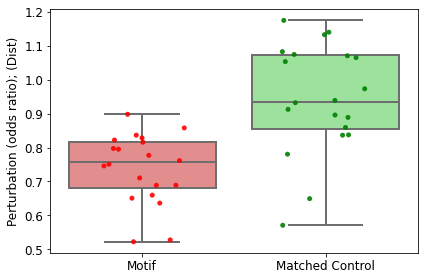

wilcoxon p = 0.0007959163393098394


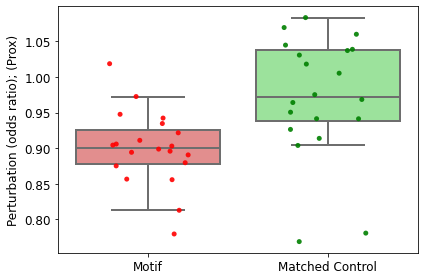

wilcoxon p = 0.8498180212406273


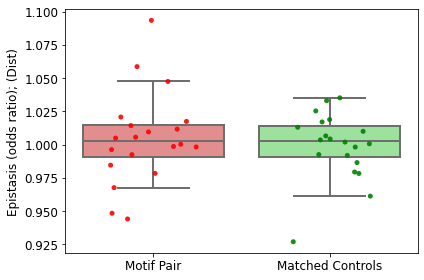

wilcoxon p = 0.5162077306368925


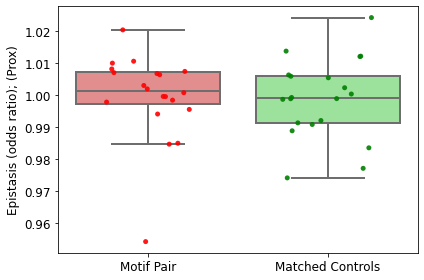

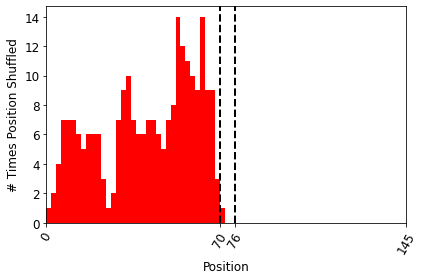

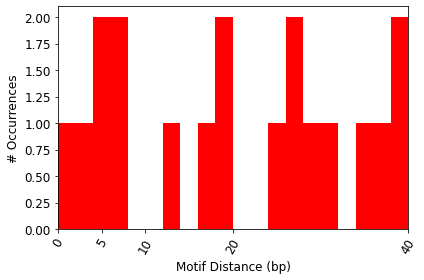

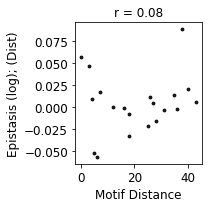

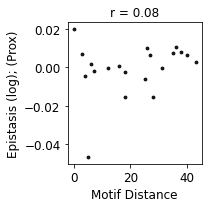

In [78]:
#Inspect epistasis ablation designs

experiment_prefix = 'TGTA_flank_GC'

n_sequences = 20

window_size = 6

cell_type_1_ix = 0
cell_type_2_ix = 6

score_ix = 2

pred_cell_type_2_ix = 6

bg_mode = 'unif'

df_abl, _ = _inspect_epistatis_ablation(
    experiment_prefix,
    n_sequences=n_sequences,
    window_size=window_size,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    score_ix=score_ix,
    pred_cell_type_2_ix=pred_cell_type_2_ix,
    bg_mode=bg_mode
)


In [111]:
#Find sequences with a canonical CSE hexamer and GT-rich downstream motif

n_wt = 100

window_size = 10

cano_cse_str  = "AAATAAAA|AATAAAAA|AAAATAAA|AATTAAAA|AAATTAAA|ATTAAAAA"
cano_cse_str += "|AAATAAAT|AATAAATT|TTAATAAA|AATTAAAT|TAATTAAA|ATTAAATT"

#df['cano_cse'] = df['seq'].str.slice(60, 80).str.contains("AATAAA|ATTAAA")
df['cano_cse'] = df['seq'].str.slice(60, 80).str.contains(cano_cse_str)

tgt_str  = "GTGTGTGT|GTGTGTCT|GTGTCTGT|GTCTGTGT|CTGTGTGT|GTGTGTTT"
tgt_str += "|GTGTTTGT|GTTTGTGT|TTGTGTGT|GTGTCTTT|GTGTTTCT|GTTTGTCT|TTGTCTGT"

#df['n_tgt'] = df['seq'].str.slice(80, 120).str.count("GTGTGT|GTGTCT|TTGTTT|TTTGTT")
df['n_tgt'] = df['seq'].str.slice(80, 120).str.count(tgt_str)

df['use_cse'] = df['seq'].str.slice(0, 60).str.contains("AATAAA|ATTAAA")

wt_index = np.nonzero((((df['n_tgt'] >= 1) & (df['cano_cse'] == 1)) & (df['use_cse'] == 0)).values)[0]

#Shuffle index positions
np.random.shuffle(wt_index)

df_tgt = df.iloc[wt_index].copy().reset_index(drop=True)

def _find_tgt(s) :
    
    s_list = tgt_str.split("|")
    
    for s_motif in s_list :
        s_pos = s.find(s_motif)
        if s_pos != -1 :
            return s_pos
    
    return -1

#Find motif positions
df_tgt['pos_1'] = df_tgt['seq'].apply(lambda x: 80 + _find_tgt(x[80:]) - 1)
df_tgt['pos_2'] = 70 - (window_size - 6) // 2

#Sample null positions (controls)
def _find_null_pos(row) :
    pos_1 = row['pos_1']
    pos_2 = row['pos_2']
    
    poses_null = []
    pos_null = 0
    while pos_null < 70 - window_size :
        if not (pos_null + window_size - 1 >= pos_1 and pos_null < pos_1 + window_size) and not (pos_null + window_size - 1 >= pos_2 and pos_null < pos_2 + window_size) :
            poses_null.append(pos_null) 
    
        pos_null += 1
    
    pos_null = np.random.choice(poses_null)
    
    return pos_null

df_tgt['pos_null'] = df_tgt.apply(_find_null_pos, axis=1)

#Filter on minimum spacing to avoid flank overlap
df_tgt['motif_distance'] = np.abs(df_tgt['pos_2'] - df_tgt['pos_1']) - window_size

df_tgt = df_tgt.query("motif_distance >= 0 and pos_1 >= 0 and pos_2 >= 0").iloc[-n_wt:].copy().reset_index(drop=True)

print("len(df_tgt) = " + str(len(df_tgt)))


len(df_tgt) = 100


In [112]:
#Store ablated wt sequences and their scrambled mutants

#Parameter configuration
experiment_prefix = 'AWTAAA_GT'

df_exp = df_tgt

window_size = 10

cell_type_1_ix = 0
cell_type_2_ix = 7

score_ix = 2

pred_cell_type_2_ixs = [7]

shuffle_region = 'dn'

bg_mode = 'unif'

_scramble_sequences(
    experiment_prefix,
    df_exp,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    pred_cell_type_2_ixs=pred_cell_type_2_ixs,
    score_ix=score_ix,
    shuffle_region=shuffle_region,
    bg_mode=bg_mode,
    n_shuffles=5,
    shuffle_window_size=window_size,
)


len(df_abl_wt) = 100
len(df_abl_1) = 100
len(df_abl_2) = 100
len(df_abl_2_null) = 100
len(df_abl_1_and_2) = 100
len(df_abl_1_and_null) = 100
len(df_abl) = 100
len(df_abl_null) = 100
wilcoxon p = 8.11073081390608e-34


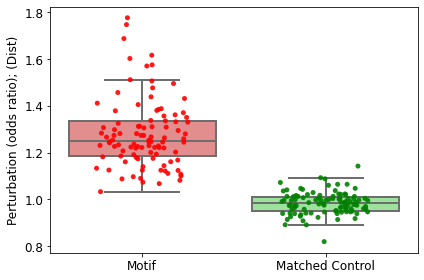

wilcoxon p = 0.009066422298818343


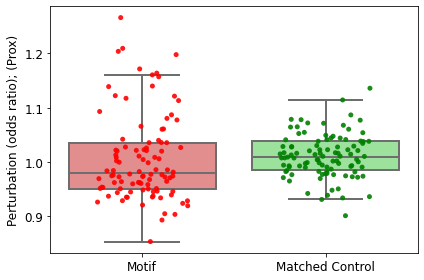

wilcoxon p = 5.89271142901495e-23


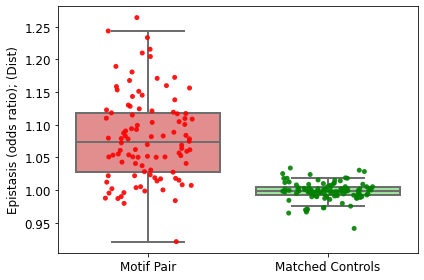

wilcoxon p = 0.012913417898559274


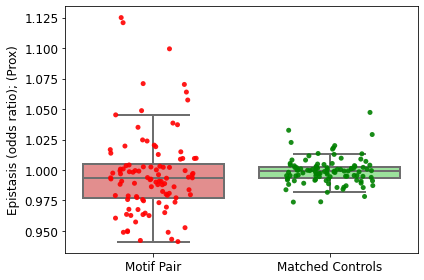

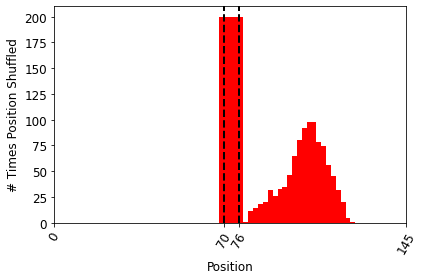

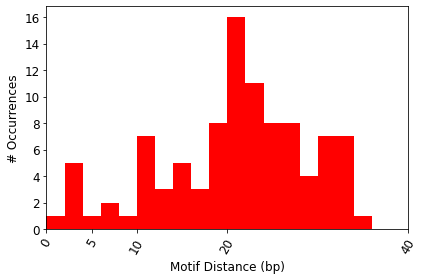

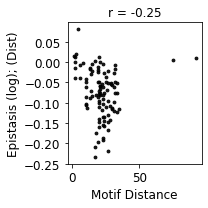

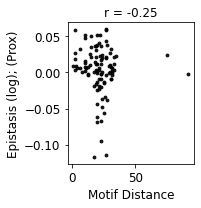

In [113]:
#Inspect epistasis ablation designs

experiment_prefix = 'AWTAAA_GT'

n_sequences = 100

window_size = 10

cell_type_1_ix = 0
cell_type_2_ix = 7

score_ix = 2

pred_cell_type_2_ix = 7

bg_mode = 'unif'

df_abl, _ = _inspect_epistatis_ablation(
    experiment_prefix,
    n_sequences=n_sequences,
    window_size=window_size,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    score_ix=score_ix,
    pred_cell_type_2_ix=pred_cell_type_2_ix,
    bg_mode=bg_mode,
    epi_sign=1.,
)
